## Method 2a, Top ALS Rating: fold-in new user to utility matrix, select highest rated games
### Model hyperparameter tuning and evaluation

### Springboard Capstone 2 project: building a recommendation engine
### John Burt

The goal of my project is to develop a working board game recommender using a dataset of explicit game ratings from the boardgamegeek.com forum site. My idea was to ask a user to name some games that they like, and my recommender algorithm will use those games to predict other games the user might like. The first problem I encountered was that any user asking for a recommendation will be unknown to the system - i.e., they are "new users" and that presents a classic cold start issue: how do you give a recommendation if you don't know much about the user? Well, we do have the user's "liked games" to work with, but any model will need to somehow match that pattern of preferences to the preference patterns in the existing data.

### Model description
The second recommender model I developed is actually what I would call the "baseline" model: that is, it's based on the most common means of generating recommendations: using ALS based matrix factorization on the target user's ratings to fill in estimated ratings for all items, then selecting the highest rated to use as recommendations. The problem with this method for new users is that you need to "fold-in" the new user: add their ratings to the dataset and re-factorize the matrix. This is very CPU and memory intensive and not a viable production solution unless you can apply some tricks that I can't replicate here. However, it is worth testing the "baseline" procedure against my initial solution. 

This version of the "Top ALS rating" recommender takes a user's "liked games", adds the user to the utility matrix (the "liked" games are all rated 10), and then factorizes the ratings matrix using ALS to estimate the user's ratings for all other games. The algorithm then selects the top rated games as recommendations, excluding the input "liked games".

- Note: For this analysis, I'm cheating a little bit: I ALS factorize all of my test users at the same time for each hyperparameter run, because otherwise the tuning would take forever. This may have an effect on the results, but given that the test users are randomly selected and only 10% of the total data, it seems unlikely to be noticeable.

### Evalution function
As with all models tested, I'm using a custom evaluation function to tune and assess the model:

- Dataset is the unfilled user x game ratings matrix, train/test split by user.
- For each test user:
    - From N*2 top rated games, randomly select N as "liked games" to use as model input (X values).
    - Remaining N top rated games assigned as holdouts to test for recommendations (y values).
    - User score = # holdout games recommended / N
    - The overall score is the mean user score for all test users.

### Purpose of this notebook:

Tune hyperparameters and evaluate the Top ALS rating new-user foldin model for various metrics.



## Load data


In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

from datetime import datetime

# import utility functions, force reload 
import sys
sys.path.append('./')
import recsys_utilities
import importlib
importlib.reload(recsys_utilities)

pd.options.display.max_rows = 100

srcdir = './data/'

# load the filled item-user utility matrix
df = pd.read_hdf(srcdir+'bgg_game_mx_unfilled_v2.h5', 'mx')

print('original: #games X #users:', df.shape)


original: #games X #users: (12120, 65168)


## Reduce the data

In [2]:
numusers = 30000
numgames = 6000
gameidx = np.array(range(numgames))
np.random.shuffle(gameidx)
useridx = np.array(range(numusers))
np.random.shuffle(useridx)
df = df.iloc[gameidx, useridx]
print('reduced: #games X #users:', df.shape)


reduced: #games X #users: (6000, 30000)


### Split data into train and test sets



In [3]:
from recsys_utilities import train_test_split_utilitymx

# test output:
n_top = 20
n_liked = int(n_top/2)
n_recs = n_liked

# transpose so users = rows
df_u = df.T

# change index name to userID
df_u.index.name = 'userID'

# make userID a column
df_u = df_u.reset_index()
    
# this function splits user x item ratings matrix into 
#  train and test sets, then it splits the test set into 
#  two sets of top rated game IDs for each user. 
train, test, test_X, test_y = train_test_split_utilitymx(df_u, 
                test_size=.1, n_liked=n_liked, n_recs=n_recs)

print('train set:',train.shape, 
      '  test set:',test_X.shape, test_y.shape)


train set: (27000, 6000)   test set: (3000, 10) (3000, 10)


## Implement recommender as sklearn estimator object

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import TruncatedSVD, PCA
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from recsys_utilities import do_ALS_df

class Recommender_ALS_foldin(BaseEstimator, ClassifierMixin):
    """recommender engine as an estimator"""

    def __init__(self, 
                regularization=0.1, 
                n_factors=100,
                n_iterations=8,
                scale=True,
                weighted=True,
                bm25_K1=10,
                bm25_B=0.8,
                verbose=False):
        """
        Called when initializing the model
        """
        # model parameters
        self.regularization = regularization
        self.n_factors = n_factors
        self.n_iterations = n_iterations
        self.scale = scale
        self.weighted = weighted
        self.bm25_K1 = bm25_K1
        self.bm25_B = bm25_B
        
        self.verbose = verbose

        # internal data used for making recommendations
        self.util_mx = None

    # ******************************************************************
    def set_params(self, **params):
        self.__dict__.update(params)

    # ******************************************************************
    def do_ALS(self, X):
        trained_mx, item_factors, user_factors = do_ALS_df(
            X, ALS_method='implicit', 
            n_iterations=self.n_iterations, 
            regularization=self.regularization, 
            n_factors=self.n_factors, 
            verbose=self.verbose,
            scale=self.scale,
            weighted=self.weighted,
            bm25_K1=self.bm25_K1,
            bm25_B=self.bm25_B,
            use_native=True,
            use_cg=True,
            use_gpu=False,
            )   
        
        return trained_mx
        
    # ******************************************************************
    def fit(self, X, y=None):
        """ store utility matrix in model   
            X = pd DataFrame utility matrix in user x item format
            Note: no training is done here, since the fold-in 
                    factorization procedure happens at predict.
        """
        
        # fill utility matrix using ALS if it contains NaNs
        self.util_mx = X
        
        # create array of game IDs
        self.item_IDs = np.array(X.index)

        return self

    # ******************************************************************
    def recommend_games_by_top_ratings(self, umx_f, userID, num2rec=10): 
        """With filled user x item rating matrix umx_f, locate ratings
        for userID, sort them and return the num2rec top rated itemIDs"""
        # descending sort this user's ratings to get 
        # indices of top rated items
        ind = np.argsort(-umx_f.loc[userID].values)
        # return top num2rec item IDs
        return umx_f.columns.values[ind[:num2rec]]
    
    # ******************************************************************
    def fold_in_new_users(self, liked_items):

        # create dataframe filled with NaNs
        test_df = pd.DataFrame(np.nan, index=liked_items.index, 
                               columns=self.util_mx.columns)

        # add 10 ratings for all "liked" games
        for i in range(liked_items.shape[0]):
            test_df.iloc[i,:].loc[liked_items.iloc[i,:]] = 10

        # append the test users' liked games into training dataset
        util_mx_folded = pd.concat([self.util_mx, test_df],axis=0)

        return util_mx_folded

    # ******************************************************************
    def predict(self, X, num2rec=10):
        """recommend games
        X = liked item IDs for each new user
        """
        
        # fold in the new users and factorize the resulting utility matrix
        umx_f = self.do_ALS(self.fold_in_new_users(X))
        
        # recommend game IDs for each row of liked games in X
        y = np.zeros([X.shape[0], num2rec])
        for i in range(X.shape[0]):
            y[i,:] = self.recommend_games_by_top_ratings(umx_f, X.index[i], num2rec=num2rec)            

        return y

    # ******************************************************************
    def score(self, y_true, y_pred):
        """mean percent of y_true game IDs in y_pred
        Both arrays are shape [num_users, num_gameIDs]"""
        
        n_recced = y_pred.shape[1]

        # #recced==holdout_y / #recced
        result = np.zeros([y_true.shape[0]])
        for i,(true_vals, pred_vals) in enumerate(zip(y_true, y_pred)):
            result[i] = len(set(true_vals).intersection(pred_vals))/n_recced
        
        return np.mean(result)
    

## Hyperparameter optimization using Baysian methods

I'm using the hyperparameter tuning package [hyperopt](https://github.com/hyperopt/hyperopt).


In [5]:
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import f1_score, roc_auc_score
from time import time
from hyperopt import tpe, hp, fmin, Trials
from time import time
from hyperopt import space_eval

# model defaults
defaults = {
    'n_factors': 500,
    'weighted': False, #True
    'bm25_K1': 4,
    'bm25_B': 0.5,
    'n_iterations': 10,
    'verbose': False,
    'scale': True,
    'regularization': 0.3,
    }
 
# hyperopt parameter space
# param space if B25 weighting isn't used
paramspace = {
    'n_factors': 10+hp.randint('n_factors', 200),
    'regularization': hp.uniform('regularization', 0.01, 1.0),
    }
                       
# hyperopt objective function
def objective(params):
    rec = Recommender_ALS_foldin(**defaults)
    rec.set_params(**params)
    rec.fit(train)
    y_pred = rec.predict(test_X, num2rec=n_recs)
    score = rec.score(test_y.values, y_pred)
    return 1-score

# The Trials object will store details of each iteration
trials = Trials()
    
# Run the hyperparameter search using the tpe algorithm
t0 = time()
print('  tune model')
best = fmin(fn=objective, space=paramspace, algo=tpe.suggest, max_evals=50, trials=trials)
print('    done in %0.3fs,'%(time() - t0))

# Get the values of the optimal parameters
best_params = space_eval(paramspace, best)
print('\n  Best parameters:',best_params)   

    

  tune model
100%|███████████████████████████████████████████████████| 50/50 [36:34<00:00, 43.89s/it, best loss: 0.8437666666666667]
    done in 2194.470s,

  Best parameters: {'n_factors': 19, 'regularization': 0.5585631935386431}


## Plotting the optimization results

avg best error: 0.8437666666666667


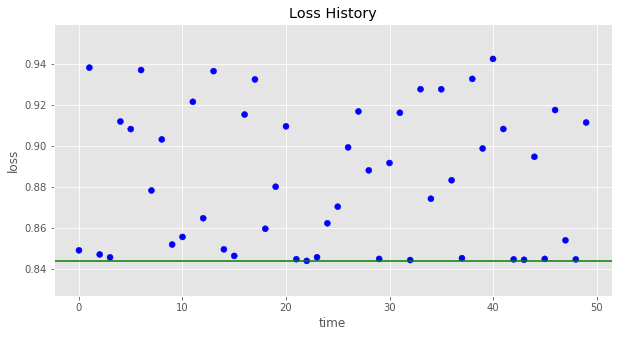

Showing Histogram of 50 jobs


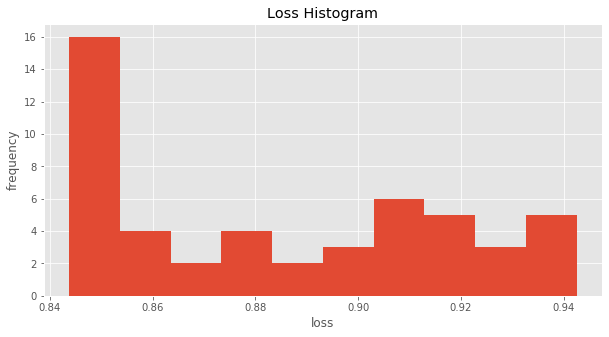

finite loss range 0.8437666666666667 0.9425333333333333 -0.15623333333333334


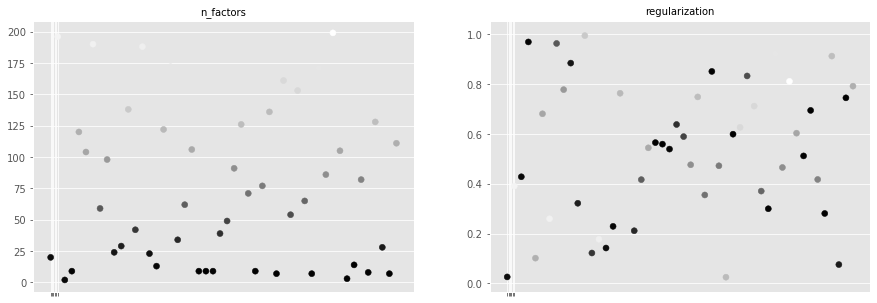

In [6]:
import hyperopt.plotting

plt.figure( figsize=(10,5))
hyperopt.plotting.main_plot_history(trials)
plt.figure( figsize=(10,5))
hyperopt.plotting.main_plot_histogram(trials)
plt.figure( figsize=(15,5))
hyperopt.plotting.main_plot_vars(trials)


## Plot performance of hyperparams across the range tested

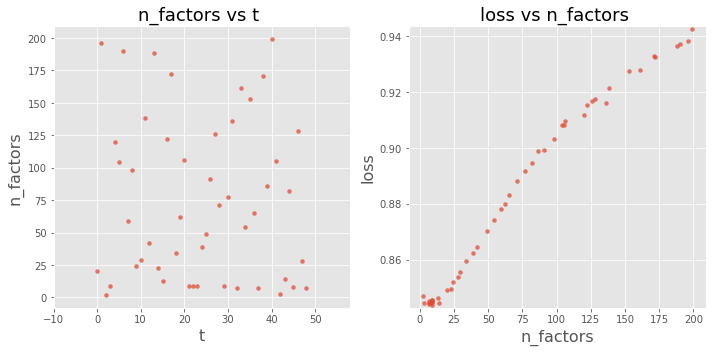

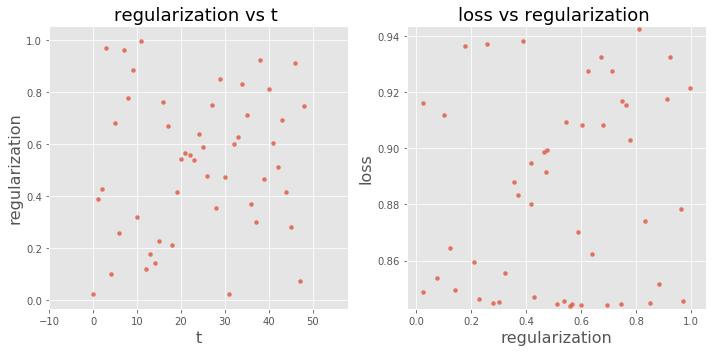

In [7]:

# only get x and y vals for plotting if there is an associated 
#  loss value. 
#  Additionally, need to deal with nested results 
def get_plot_vals(results, paramname):
    x_val = [t['tid'] for t in results]
    y_val = [t['misc']['vals'][paramname] for t in results]
    # list of lists means some entries are empty
    if type(y_val[0]) is list: 
        ytemp = np.array([y[0] if y else np.nan for y in y_val])
        y_val = np.array(ytemp)[~np.isnan(ytemp)]
        x_val = np.array(x_val)[~np.isnan(ytemp)]
    x_loss = [t['misc']['vals'][paramname] for t in results]
    y_loss = [t['result']['loss'] for t in results]
    # list of lists means some entries are empty
    if type(x_loss[0]) is list:
        xtemp = np.array([x[0] if x else np.nan for x in x_loss])
        y_loss = np.array(y_loss)[~np.isnan(xtemp)]
        x_loss = np.array(xtemp)[~np.isnan(xtemp)]
    return x_val, y_val, x_loss, y_loss

# if 'loss' not in results[-1]['result']:
#     results = results[:-1]

results = trials.trials[:-1]
# results = trials.trials
times = [t['tid'] for t in results]

for paramname in results[0]['misc']['vals'].keys():
    x_val, y_val, x_loss, y_loss = get_plot_vals(results, paramname)
    
    f, ax = plt.subplots(1,2, figsize=(10,5))
    xs = times
    # param value over time
    ax[0].set_xlim(xs[0]-10, xs[-1]+10)
    ax[0].scatter(x_val, y_val, s=20, linewidth=0.01, alpha=0.75)
    ax[0].set_title('%s vs t '%(paramname), fontsize=18)
    ax[0].set_xlabel('t', fontsize=16)
    ax[0].set_ylabel(paramname, fontsize=16)
    
    # loss vs param val
    ax[1].set_ylim(min(y_loss)-.001, max(y_loss)+.001)
    ax[1].scatter(x_loss, y_loss, s=20, linewidth=0.01, alpha=0.75)
    ax[1].set_title('loss vs %s '%(paramname), fontsize=18)
    ax[1].set_xlabel(paramname, fontsize=16)
    ax[1].set_ylabel('loss', fontsize=16)
    plt.tight_layout()


## Cross-validate model performance using the best parameters

In [8]:
from sklearn.model_selection import KFold
from recsys_utilities import get_test_Xy
# import utility functions, force reload 
import sys
sys.path.append('./')
import recsys_utilities
import importlib
importlib.reload(recsys_utilities)

def cv_score(clf, X, nfold = 5):
    """Calculate nfolds CV scores"""
    scores = []
    print('Working:',end='')
    # split data into train/test groups, nfold times
    for train_idx, test_idx in KFold(nfold,shuffle=True).split(X): 
        # fit the recommender
        clf.fit(X.iloc[train_idx,:]) 
        test_X, test_y = get_test_Xy(X.iloc[test_idx,:], 
                                     n_liked=n_liked, n_recs=n_recs )
        # evaluate score function on held-out data
        y_pred = clf.predict(test_X, num2rec=n_recs)
        scores.append(clf.score(test_y.values, y_pred))
        print('.', end='')
        
    return scores

# prep source dataframe
try: 
    df_u = df_u.set_index('userID') 
except: 
    pass

# create the recommender object
clf = Recommender_ALS_foldin(**defaults)
clf.set_params(**best_params)

scores = cv_score(clf, df_u, nfold = 5)

print('\n')
for i, score in enumerate(scores):
    print('Fold %d score = %1.4f'%(i,score))
    
print('\nMean score = %1.4f'%(np.mean(scores)))

Working:.....

Fold 0 score = 0.1601
Fold 1 score = 0.1565
Fold 2 score = 0.1608
Fold 3 score = 0.1597
Fold 4 score = 0.1565

Mean score = 0.1587
